In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-30/validation_data.csv
/kaggle/input/data-storm-30/train_data.csv
/kaggle/input/data-storm-30/test_data.csv
/kaggle/input/data-storm-30/DataStorm3.0_KaggleProblemStatement.pdf


In [44]:
df = pd.read_csv("/kaggle/input/data-storm-30/train_data.csv")


In [45]:
pd.set_option('display.max_rows', 10)

In [46]:
training_range = pd.date_range('2021-10-01', '2022-02-13')
testing_range = pd.date_range('2022-02-20', '2022-03-13', freq='W-SUN')

In [47]:
def data_for_item(item_code):
    filtered_df = df.loc[df['ItemCode'] == item_code]
    filtered_df["DateID"] = pd.to_datetime(filtered_df["DateID"], format = "%m/%d/%Y")
        
    filtered_df.set_index(filtered_df.DateID, inplace=True)
    filtered_df.drop('DateID', axis=1, inplace=True)
    filtered_df.drop('ItemCode', axis = 1, inplace = True)
    filtered_df.drop('CategoryCode', axis = 1, inplace = True)
    
    for date in training_range:
        if date not in filtered_df.index:
            filtered_df.loc[date] = [0]
    
    filtered_df = filtered_df.sort_index()
        
    weekly_sales = filtered_df.groupby(pd.Grouper(freq='W')).sum()
    weekly_sales.rename(columns = {'DailySales': 'WeeklySales'}, inplace = True)
    weekly_sales = create_lag(weekly_sales)
    weekly_sales['month'] = weekly_sales.index.month
    weekly_sales['week'] = weekly_sales.index.weekofyear
    train_x = weekly_sales.loc[:, weekly_sales.columns != 'WeeklySales']
    train_y = weekly_sales['WeeklySales']
    return weekly_sales, train_x, train_y
    

In [48]:
def create_lag(df3):
    dataframe = pd.DataFrame()
    for i in range(2, 0, -1):
        dataframe['t-' + str(i)] = df3.WeeklySales.shift(i)
    df4 = pd.concat([df3, dataframe], axis=1)
    df4.dropna(inplace=True)
    return df4

In [49]:
weekly_sales, train_x, train_y = data_for_item(172033)
weekly_sales.head()

,WeeklySales,t-2,t-1,month,week
DateID,,,,,
2021-10-17,20,18.0,44.0,10,41
2021-10-24,22,44.0,20.0,10,42
2021-10-31,47,20.0,22.0,10,43
2021-11-07,178,22.0,47.0,11,44
2021-11-14,177,47.0,178.0,11,45


In [50]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [51]:
def train_predict(weekly_sales, train_x, train_y):
    model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state = 1)

    fit = model.fit(train_x, train_y)
    results = []
    
    for date in testing_range:
        prev_row = weekly_sales.iloc[-1]
        test_x = pd.DataFrame({'month': [date.month], 
                               'week': [date.weekofyear], 
                               't-1':[prev_row['WeeklySales']], 
                               't-2': [prev_row['t-1']]})
        
        prediction = round(fit.predict(test_x)[0])
        test_x['WeeklySales'] = [prediction]
        test_x.index = [date]
        #print(test_x)
        weekly_sales = weekly_sales.append(test_x)
        results.append(prediction)
    
    #print(weekly_sales)
    return results
        

In [52]:
def predict_for_one_item(item_code):
    weekly_sales, train_x, train_y = data_for_item(item_code)
    result = train_predict(weekly_sales, train_x, train_y)
    return result

In [53]:
def accuracy(actual, pred):
    diff = np.sum(np.abs(actual - pred))
    return diff / np.sum(actual)

In [54]:
def predict_for_test(path):
    val_df = pd.read_csv(path)
    results = {}
    for item_code in val_df.ItemCode.unique():
        print(item_code)
        sales = predict_for_one_item(item_code)
        weeks = {}
        for i in range(4):
            weeks['w'+str(i+1)] = sales[i]
        results[item_code] = weeks
    val_df['Predictions'] = val_df.apply(lambda row: results[row.ItemCode][row.Week], axis = 1)
    val_df['ID'] = val_df.apply(lambda row: row.CategoryCode + '_' + str(row.ItemCode) + '_' + row.Week, axis = 1)
    
    if 'WeeklySales' in val_df:
        print("Accuracy:", accuracy(val_df.WeeklySales.values, val_df.Predictions.values))
    return val_df
    

In [55]:
val_df = predict_for_test('/kaggle/input/data-storm-30/validation_data.csv')

1044502
1105009
913561
1048975
17287
371239
1098502
1074823
23569
397213
211309
1058713
1032550
1071106
40759
1067092
1101661
210868
379249
75886
1044682
1090303
1084498
1064473
1030948
1090276
138742
24136
836125
64978
1032541
865933
836152
839356
906586
30877
173617
1006108
1064572
416212
35584
1070836
43657
110320
3427
877624
1090105
248272
124954
1097143
1098493
745945
48940
86974
1076938
59047
172582
1044619
1013335
1015621
1047130
132028
1010068
1066570
1076920
1071124
172033
399220
142756
1006009
1003156
1090294
99079
1050046
1026871
59749
118033
3418
124774
1003147
7666
245581
1081087
1061638
17296
1090240
76399
131983
50785
755584
267496
20824
1060909
1090114
1032586
Accuracy: 0.46747993173629987


In [56]:
def data_for_item_sales(item_code):
    filtered_df = df.loc[df['ItemCode'] == item_code]
    filtered_df["DateID"] = pd.to_datetime(filtered_df["DateID"], format = "%m/%d/%Y")
        
    filtered_df.set_index(filtered_df.DateID, inplace=True)
    filtered_df.drop('DateID', axis=1, inplace=True)
    filtered_df.drop('ItemCode', axis = 1, inplace = True)
    filtered_df.drop('CategoryCode', axis = 1, inplace = True)
    
    for date in training_range:
        if date not in filtered_df.index:
            filtered_df.loc[date] = [0]
    
    filtered_df = filtered_df.sort_index()
        
    weekly_sales = filtered_df.groupby(pd.Grouper(freq='W')).sum()
    weekly_sales.rename(columns = {'DailySales': 'WeeklySales'}, inplace = True)
    weekly_sales = create_lag(weekly_sales)
    weekly_sales['month'] = weekly_sales.index.month
    weekly_sales['week'] = weekly_sales.index.weekofyear
    train_x = weekly_sales.loc[:, weekly_sales.columns != 'WeeklySales']
    train_y = weekly_sales['WeeklySales']
    return filtered_df, weekly_sales

In [57]:
import pylab as plt

In [58]:
item = 172033
daily, weekly = data_for_item_sales(item)


Text(0.5, 1.0, 'Daily sales of item 172033')

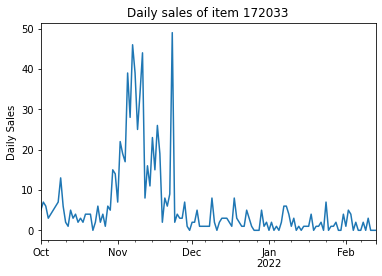

In [59]:

day_fig = daily.plot(legend = None)
plt.xlabel("")
plt.ylabel("Daily Sales")
plt.title("Daily sales of item {}".format(item))

Text(0.5, 1.0, 'Weekly sales of item 172033')

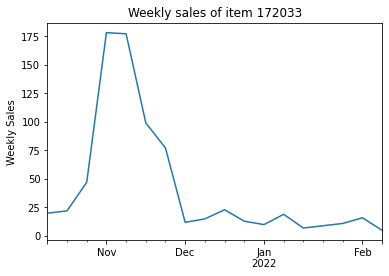

In [60]:
week_fig = weekly.WeeklySales.plot()
plt.xlabel("")
plt.ylabel("Weekly Sales")
plt.title("Weekly sales of item {}".format(item))

Text(0.5, 1.0, 'Weekly sales of item 172033 with predictions\n')

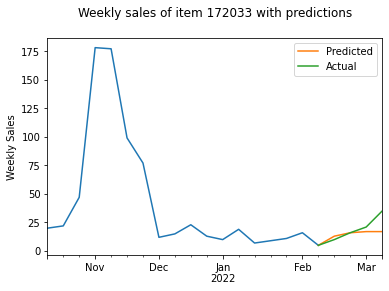

In [61]:
prediction = predict_for_one_item(item)
ax = weekly.WeeklySales.plot()
preds = pd.DataFrame({"Predicted":prediction,
                     "Actual": val_df[val_df.ItemCode == item].sort_values(by = ["Week"]).WeeklySales.values}, 
                     index = testing_range)
preds.loc[training_range[-1]] = [weekly.loc[training_range[-1]].WeeklySales] * 2
preds = preds.sort_index()
preds.plot(ax = ax)
acc = accuracy(preds.Actual.values, preds.Predicted.values)
plt.xlabel("")
plt.ylabel("Weekly Sales")
plt.title("Weekly sales of item {} with predictions\n".format(item))


In [62]:
def pred_for_category(catcode):
    total_sales = np.zeros((len(weekly), ), dtype = int)
    total_predicted = np.zeros((4, ), dtype = int)
    
    for item_code in df[df.CategoryCode == "category_" + str(catcode)].ItemCode.unique():
        weekly_sales, train_x, train_y = data_for_item(item_code)
        total_sales += weekly_sales.WeeklySales.values
        predictions = np.array(train_predict(weekly_sales, train_x, train_y))
        total_predicted += predictions
        
    cat_sales = pd.DataFrame({'WeeklySales': total_sales}, index = weekly_sales.index)
    cat_pred = pd.DataFrame({'Predicted': total_predicted}, index = testing_range)
    cat_pred.loc[training_range[-1]] = cat_sales.loc[training_range[-1]].values
    cat_pred.sort_index(inplace = True)
    return cat_sales, cat_pred
        

In [63]:
cat_totals = {}
for i in range(1, 5):
    cat_sales, cat_pred = pred_for_category(i)
    print(i)
    cat_totals[i] = cat_sales, cat_pred

1
2
3
4


In [81]:
def plot_cat(catax, catcode):
    cat_sales, cat_pred = cat_totals[catcode]
    avg_sales = np.mean(cat_sales.WeeklySales.values)
    cat_sales.plot(ax = catax, legend = None, label = 'Weekly Sales')
    cat_pred.plot(ax = catax, legend = None)
    catax.axhline(y = avg_sales, color = 'k', label = 'Average', ls = '--')
    return catax

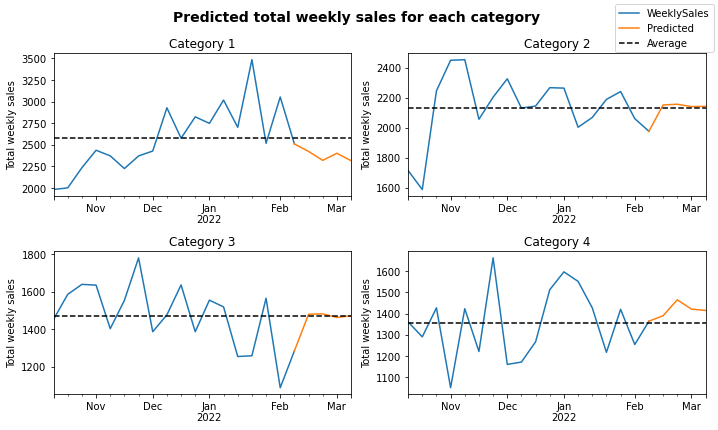

In [82]:
fig, axs = plt.subplots(2, 2,figsize=(10, 6))
plot_cat(axs[0,0], 1)
axs[0,0].set_title("Category 1")
plot_cat(axs[0,1], 2)
axs[0,1].set_title("Category 2")
plot_cat(axs[1,0], 3)
axs[1,0].set_title("Category 3")
plot_cat(axs[1,1], 4)
axs[1,1].set_title("Category 4")
handles, labels = axs[0,0].get_legend_handles_labels()

plt.suptitle("Predicted total weekly sales for each category", fontweight='bold', fontsize = 14)
for ax in axs.flat:
    ax.set(xlabel='', ylabel='Total weekly sales')
fig.legend(handles, labels)
fig.tight_layout()

In [66]:
cat_sales.loc[training_range[-1]].WeeklySales

1364

194